In [511]:
import controllers
import controlpy
import control_utils
import dynamics_models
import experiment_utils
import numpy as np
import matplotlib.pyplot as plt
import polytope
import tqdm
import uncertainty_utils
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## Setup Drone Dynamics

In [512]:
# Dynamics Parameters
n_states = 6
n_inputs = 2
dt = 0.05
m = 0.5
l = 0.4
I = (1 / 3) * m * (l**2)
init_state = np.array([3, 3,0,.3,.3,0])
linearization_state = np.zeros(6)
state_limits = polytope.box2poly([[-2,4],[-2,4],[-np.pi/3, np.pi/3]])
u_min = -.01
u_max = 5
input_limits = polytope.box2poly([[u_min,u_max], [u_min,u_max]])
input_bounds = [np.array([u_min, u_min]), np.array([u_max, u_max])]
offset = m * dynamics_models.GRAVITY / 2

# Control Task
Q = np.diag([10,10,1,1,1,1])
R = np.eye(n_inputs)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u

# Noise and Disturbances
process_noise_var = 0
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
# disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n_states))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(5 / dt)
controller_horizon = 10
num_episodes = 10
state_reference = np.zeros(n_states)
A_state = np.hstack((state_limits.A, np.zeros((state_limits.A.shape[0],3))))
state_constraints = (A_state, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)

# Vehicle
def get_vehicle():
    vehicle = dynamics_models.PlanarQuadrotor(init_state, m, l , I, dt, process_noise)
    return vehicle

def model_callback(vehicle, controller, episode_length):
    A, B, C = control_utils.linearize_around(vehicle, controller.x_traj.value, controller.u_traj.value, vehicle.dt)
    return A, B, C

## Plotting 
figsize=(6,6)
def plot_experiment(traj_list, x_preds, ax, lims=(-3,5), lw=2, k=5):
    state_proj = state_limits.project(np.arange(2) + 1)
    ax.axis("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("x (in m)")
    ax.set_ylabel("y (in m)")
    state_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)

    for x_traj in traj_list:
        ax.plot(x_traj[0,:], x_traj[1,:], "k--")

    x_traj = traj_list[-1].T
    ax.quiver(x_traj[::k,0], x_traj[::k,1], - np.sin(x_traj[::k,2]),   np.cos(x_traj[::k,2]))

    for x_pred in x_preds[::k]:
        ax.plot(x_pred[:,0], x_pred[:,1], "r--")

## Run initial Iteration, Tracking MPC

In [513]:
vehicle = get_vehicle()
A, B, C = vehicle.get_linearization(linearization_state, np.array([offset, offset]) / 2, dt)
controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon, 
                                         Q,  R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [514]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)
init_value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
print(init_value_function[0])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.20it/s]


7025.449958528277


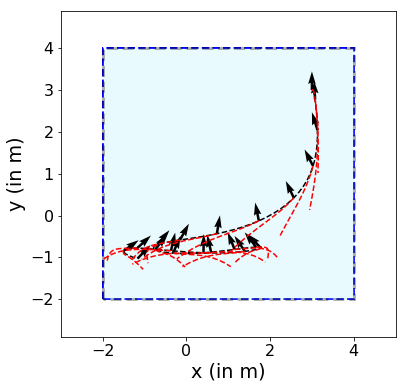

In [515]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x_init_traj.T], x_init_preds, ax)
O = polytope.Polytope(*controller.terminal_constraint)
Op = O.project([1,2])
Op.plot(ax, alpha=0.3)

## Setup LTI style LMPC

In [516]:
controller = controllers.LTI_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [517]:
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.84it/s]


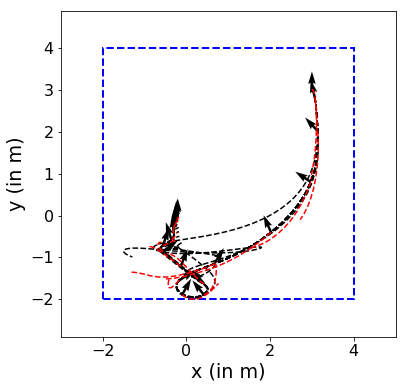

In [518]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

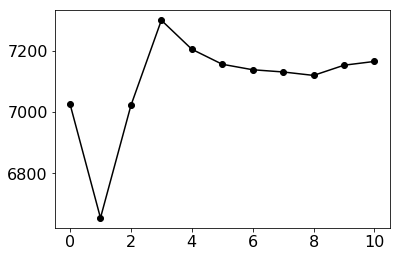

In [519]:
lti_lmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(lti_lmpc_costs, "k-o")

## Naive LTV LMPC

In [520]:
controller = controllers.LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [521]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_init_traj[:controller.N,:].T, u_init_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


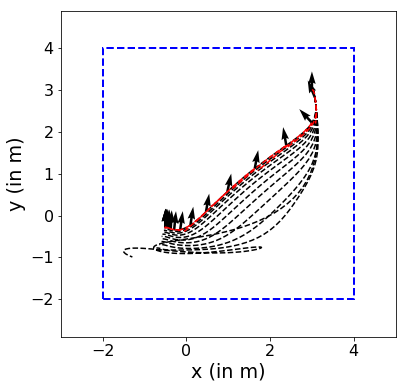

In [522]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

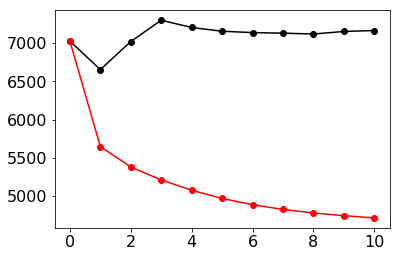

In [523]:
naive_ltv_costs = [q[0] for q in controller.value_func_list]
plt.plot(lti_lmpc_costs, "k-o")
plt.plot(naive_ltv_costs, "r-o")

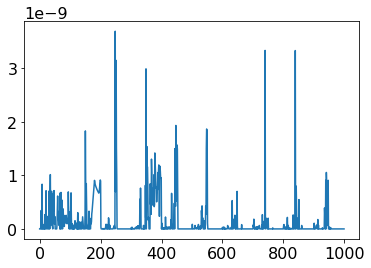

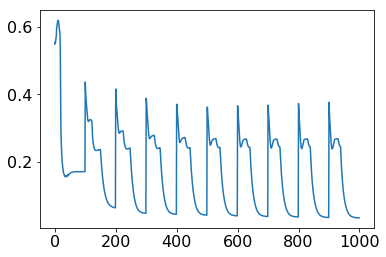

In [524]:
slack_list = [np.linalg.norm(slack) for slacks in slack_per_episode for slack in slacks]
terminal_slack_list = [np.linalg.norm(tslack) for tslacks in term_slack_per_episode for tslack in tslacks]
plt.figure()
plt.plot(slack_list)
plt.figure()
plt.plot(terminal_slack_list)

## LTI Tube LMPC
Don't RUN! COMPUTING MINIMAL INVARIANTS IN HIGH DIM IS NOT REALISTIC WITHOUT A PROPER FAST APPROXIMATION. It takes forever both in Matlab and in my python implementation, which largely uses the same methods as the MPT toolbox. Many projects that do control for "high" dimensional systems (i.e. n > 3) run into this problem. For example in [^1], they just subtract the disturbance set from the constraint sets to compute constraint tightenings... I'm sure there are a bunch of approximations that exist but they'll make things more conservative and/or also won't really be invariant. 

[^1]: A. Aswani, P. Bouffard, C. Tomlin, Extensions of Learning-Based Model Predictive Control for Real-Time
Application to a Quadrotor Helicopter

In [525]:
# num_episodes = 10

# controller = controllers.LTI_Tube_LMPC(A, B, C,
#                                      controller_horizon, 
#                                      Q, R, state_reference, 
#                                      state_constraints, input_constraints, 
#                                     (disturbance_bound.A, disturbance_bound.b))
# h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
# value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)
# controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, value_function)

In [526]:
# for episode in range(num_episodes):
#     vehicle = get_vehicle()
#     x_traj, u_traj, x_preds, u_preds = sim_traj(vehicle, controller, input_bounds)
#     value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
#     controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

## LTI MPC

In [527]:
controller = controllers.LTI_MPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)
controller.build()

In [528]:
vehicle = get_vehicle()
x_traj, u_traj, x_preds, u_preds, _, _ = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.84it/s]


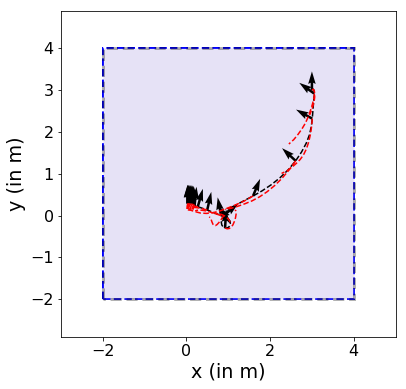

In [529]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment([x_traj.T], x_preds, ax)

Op = O.project([1,2])
Op.plot(ax=ax, alpha=0.3)
fixed_lti_mpc_cost = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)

## Local Safe Sets, TV LMPC

In [530]:
safe_set_size = 50
n_safe_set_it = 5
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

In [531]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.96it/s]


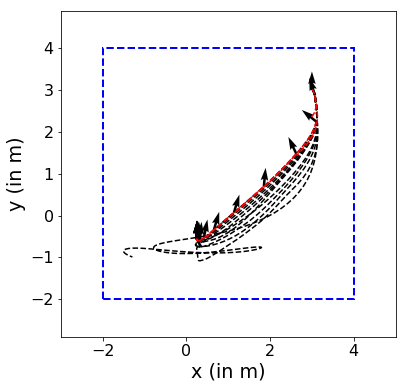

In [532]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

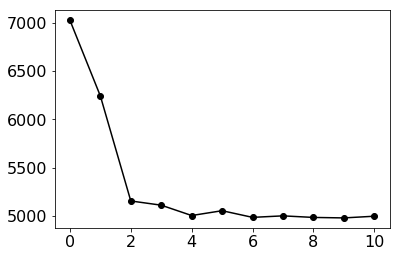

In [533]:
local_ltv_costs = [q[0] for q in controller.value_func_list]
plt.plot(local_ltv_costs, "k-o")

## True TV LMPC

In [534]:
controller = controllers.True_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, 
                                     state_constraints, input_constraints)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)

def ltv_model_callback(vehicle, controller, episode_length):
    i = controller.i
    N = controller.N
    i = min(episode_length - N, i)
    x_traj = controller.traj_list[-1][:,i:i+N]
    u_traj = controller.input_traj_list[-1][:,i:i+N]
    A, B, C = control_utils.linearize_around(vehicle, x_traj, u_traj, vehicle.dt)
    return A, B, C

In [535]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=ltv_model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.76it/s]


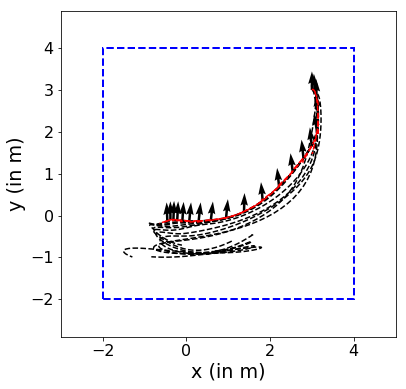

In [536]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

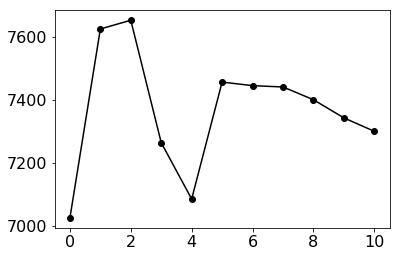

In [537]:
true_ltv_costs = [q[0] for q in controller.value_func_list]
plt.plot(true_ltv_costs, "k-o")

## Quasi LBLMPC

In [538]:
controller = controllers.LBLMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, 
                                    state_constraints, input_constraints, (disturbance_bound.A, disturbance_bound.b))
## Minimal Invariant Cannot Be Computed
alpha = 0.1
M = polytope.box2poly([[-alpha, alpha]] * n_states)
X = polytope.Polytope(*controller.state_constraints)
U = polytope.Polytope(*controller.input_constraints)
X_bar = control_utils.pontryagin_difference(X, M)
U_bar = control_utils.pontryagin_difference(U, control_utils.poly_transform(M, controller.K))
controller.state_constraints = (X_bar.A, X_bar.b)
controller.input_constraints = (U_bar.A, U_bar.b)
controller.init_constraint = (M.A, M.b)


controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)


In [539]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


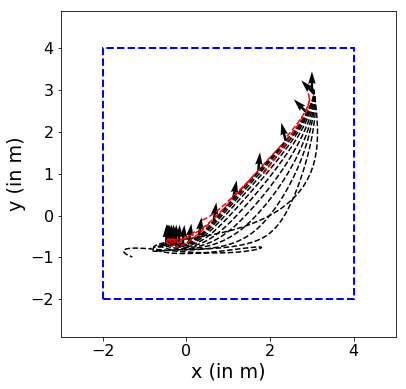

In [540]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

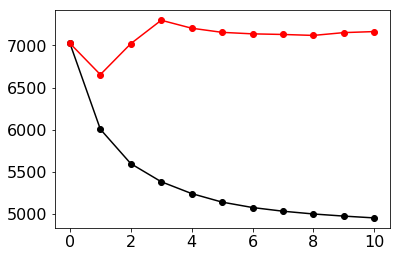

In [541]:
lblmpc_costs = [q[0] for q in controller.value_func_list]
plt.plot(lblmpc_costs, "k-o")
plt.plot(lti_lmpc_costs, "r-o")

### LTV Tube LMPC

In [542]:
## Minimal Invariant Cannot Be Computed
alpha = 0.1
M = polytope.box2poly([[-alpha, alpha]] * n_states)
minimal_invariant = (M.A, M.b)

controller = controllers.LTV_Tube_LMPC(A, B, C,
                                    controller_horizon, 
                                    Q, R, state_reference, 
                                    state_constraints, input_constraints, minimal_invariant)

controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_function)


In [543]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = get_vehicle()
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.68it/s]


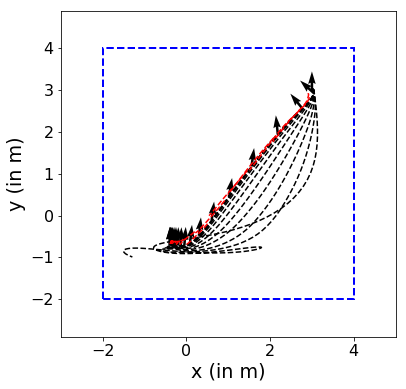

In [544]:
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax)

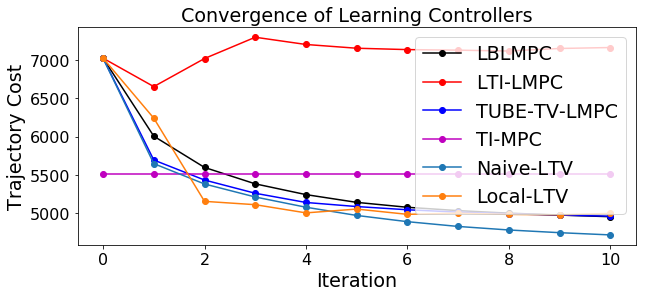

In [547]:
ltv_tube_lmpc_costs = [q[0] for q in controller.value_func_list]
plt.figure(figsize=(10,4))
plt.plot(lblmpc_costs, "k-o")
plt.plot(lti_lmpc_costs, "r-o")
plt.plot(ltv_tube_lmpc_costs, "b-o")
plt.plot(np.arange(num_episodes+1), np.ones(num_episodes+1) * fixed_lti_mpc_cost[0], "m-o")
# plt.plot(true_ltv_costs, "c-o")
plt.plot(naive_ltv_costs, "-o")
plt.plot(local_ltv_costs, "-o")
plt.xlabel("Iteration")
plt.ylabel("Trajectory Cost")
plt.title("Convergence of Learning Controllers")
names = ["LBLMPC", "LTI-LMPC", "TUBE-TV-LMPC", "TI-MPC" , "Naive-LTV", "Local-LTV"]
plt.legend(names,loc="upper right")
# plt.savefig("drone_converge_tracker_init_small_dt.png")

In [ ]:
np.linal